In [1]:
# project: p6
# submitter: kukunooru
# partner: none
# hours: 10

In [2]:
import geopandas as gpd
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
import sklearn
import sklearn.compose
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.impute
import sklearn.linear_model
import sklearn.metrics
import math
import rasterio
from matplotlib.colors import ListedColormap
import shapely 


In [3]:
#Q1
# read in data files 
counties = 'counties.geojson' 
counties = gpd.read_file(counties) 
len(counties)

72

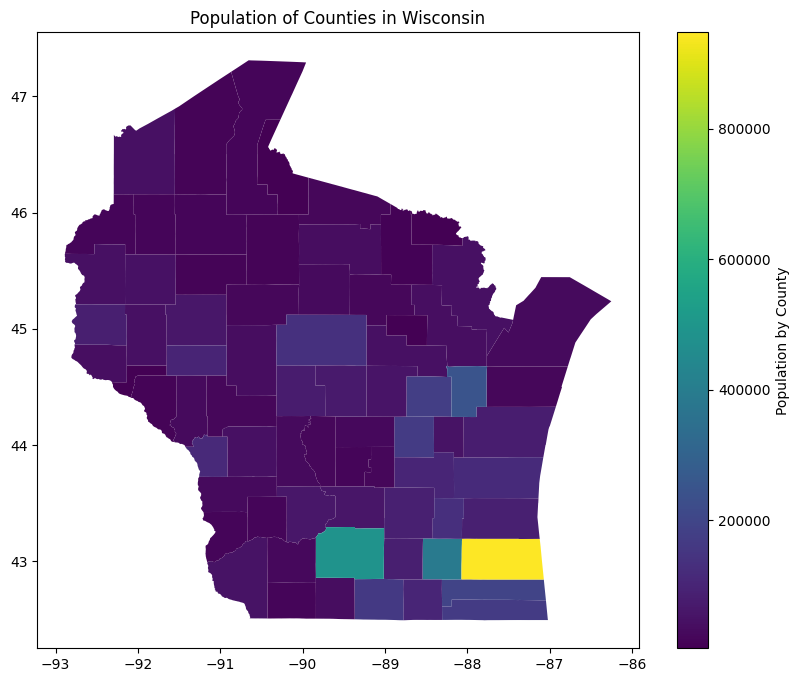

In [4]:
#Q2 
counties['POP100'] = counties['POP100'].astype(int) 
fig, ax = plt.subplots(1,1, figsize=(10, 8)) 
counties.plot(column='POP100', ax=ax, legend=True, legend_kwds={'label': "Population by County"}) 
plt.title('Population of Counties in Wisconsin') 
plt.show() 

In [5]:
con = sqlite3.connect("counties_tracts.db")
counties_tracts_area = pd.read_sql("""SELECT * FROM counties""", con)
arealand = counties_tracts_area['AREALAND'] 
counties['AREALAND'] = arealand
counties.head()
x = counties['AREALAND']
y = counties['POP100'] 
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size=0.25, random_state=250)


# pd.read_sql("""SELECT * FROM tracts""", con)

In [6]:
#Q3
test_indices = x_test.index.tolist()
counties_in_test_set = counties.loc[test_indices, 'NAME'].tolist()  # Replace 'county_name' with your actual county name column
counties_in_test_set

['Dane County',
 'Juneau County',
 'Taylor County',
 'Vilas County',
 'Rusk County',
 'Price County',
 'Jackson County',
 'Waushara County',
 'Pepin County',
 'Douglas County',
 'Ashland County',
 'Milwaukee County',
 'Waupaca County',
 'Richland County',
 'Lafayette County',
 'Washburn County',
 'Dunn County',
 'Bayfield County']

In [7]:
#Q4
model = sklearn.linear_model.LinearRegression()
X_train = np.array(x_train).reshape(-1, 1)  # Reshape to a 2D array
model.fit(X_train, y_train)
X_test = np.array(x_test).reshape(-1, 1)
model.score(X_test, y_test)

0.016720430179409274

In [8]:
#Q5
area_400 = np.array([[400 * 2590000]])   # Reshape to a 2D array
predicted_population = model.predict(area_400)
predicted_population[0]

90000.07422783462

In [9]:
hu100 = pd.read_sql("""
        SELECT c.COUNTY, SUM(t.HU100) AS HU100
        FROM counties AS c
        JOIN tracts AS t ON c.COUNTY = t.COUNTY
        GROUP BY c.COUNTY
        """, con)
hu100
counties_tracts_area = pd.merge(counties_tracts_area, hu100, on='COUNTY', how='left')  # 'inner' means only include common values
hu100List = counties_tracts_area['HU100']


In [10]:
#Q6
counties['HU100'] =  hu100List
x = counties['HU100']
y = counties['POP100'] 
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size=0.25, random_state=250)

test_indices = x_test.index.tolist()
counties_in_test_set = counties.loc[test_indices, 'NAME'].tolist()  # Replace 'county_name' with your actual county name column
counties_in_test_set

['Dane County',
 'Juneau County',
 'Taylor County',
 'Vilas County',
 'Rusk County',
 'Price County',
 'Jackson County',
 'Waushara County',
 'Pepin County',
 'Douglas County',
 'Ashland County',
 'Milwaukee County',
 'Waupaca County',
 'Richland County',
 'Lafayette County',
 'Washburn County',
 'Dunn County',
 'Bayfield County']

In [11]:
#Q7
hu100dict = {} 

for county in counties_in_test_set:
    val = counties.loc[counties['NAME'] == county, 'HU100']
    hu100dict[county] = int(val.iloc[0])
hu100dict

{'Dane County': 216022,
 'Juneau County': 14669,
 'Taylor County': 10582,
 'Vilas County': 25116,
 'Rusk County': 8883,
 'Price County': 11120,
 'Jackson County': 9727,
 'Waushara County': 14843,
 'Pepin County': 3579,
 'Douglas County': 22825,
 'Ashland County': 9656,
 'Milwaukee County': 418053,
 'Waupaca County': 25396,
 'Richland County': 8868,
 'Lafayette County': 7230,
 'Washburn County': 12979,
 'Dunn County': 17964,
 'Bayfield County': 12999}

In [12]:
#Q8
X_train = np.array(x_train).reshape(-1, 1)  # Reshape to a 2D array

cross_val_score = sklearn.model_selection.cross_val_score(model, X_train, y_train)
variance = np.average(cross_val_score)
variance

0.9739348181232653

In [13]:
#Q9
np.std(cross_val_score)

0.01693954236334351

In [14]:
#Q10
model.fit(X_train, y_train)
coefficient = round(model.coef_[0], 2)
intercept = round(model.intercept_, 2)
f"POP100 = {coefficient}*HU100 + {intercept}"

'POP100 = 2.47*HU100 + -9276.89'

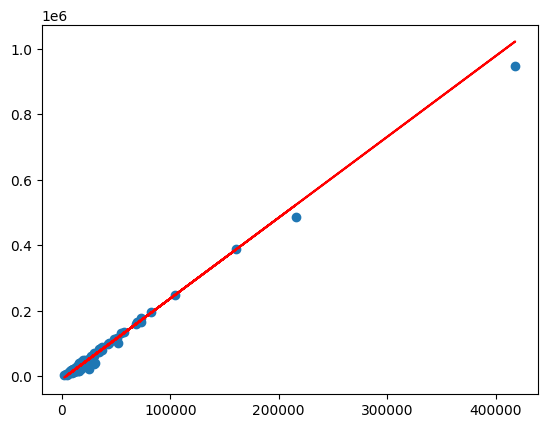

In [15]:
#Q11
x_combine = np.concatenate([x_train, x_test]) 
y_combine = np.concatenate([y_train, y_test])
plt.scatter(x_combine, y_combine)
X_combine = np.array(x_combine).reshape(-1, 1)
y_pred = model.predict(X_combine)
plt.plot(x_combine, y_pred, color = 'red')

In [16]:
#Q12
A = np.array([
    [0,0,5,8,4],
    [1,2,4,0,3],
    [2,4,0,9,2],
    [3,5,2,1,1],
    [0,5,0,1,0]
])
np.sum((A >= 3) & (A <= 6))

8

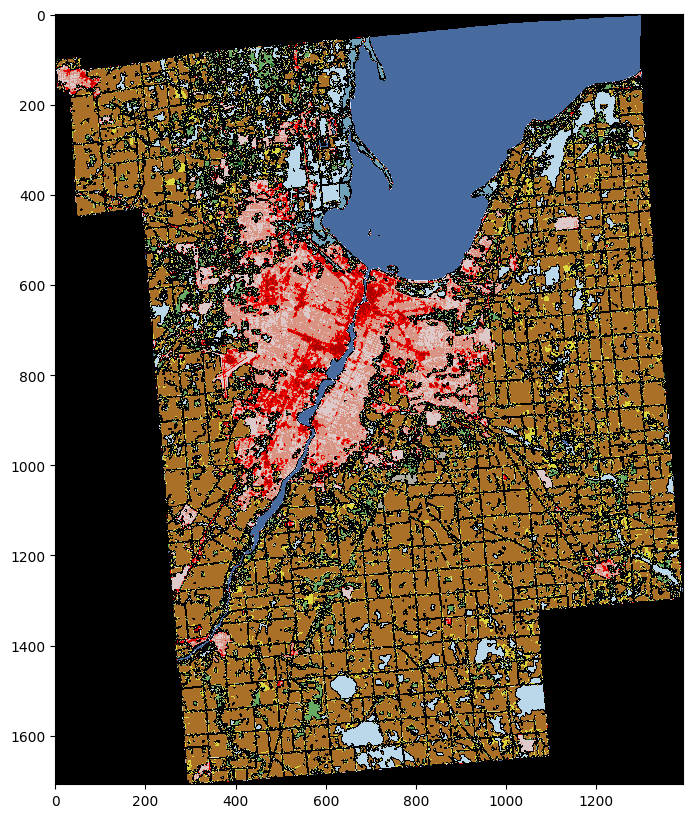

In [17]:
#Q13
from rasterio.mask import mask
land = rasterio.open("zip://../p6/land.zip!wi.tif")
brown_county = counties[counties['NAME'] == 'Brown County']
brown_county_data, _ = mask(land, brown_county.to_crs(land.crs)["geometry"], crop=True)
    
c = np.zeros((256,3))
c[0] = [0.00000000000, 0.00000000000, 0.00000000000]
c[11] = [0.27843137255, 0.41960784314, 0.62745098039]
c[12] = [0.81960784314, 0.86666666667, 0.97647058824]
c[21] = [0.86666666667, 0.78823529412, 0.78823529412]
c[22] = [0.84705882353, 0.57647058824, 0.50980392157]
c[23] = [0.92941176471, 0.00000000000, 0.00000000000]
c[24] = [0.66666666667, 0.00000000000, 0.00000000000]
c[31] = [0.69803921569, 0.67843137255, 0.63921568628]
c[41] = [0.40784313726, 0.66666666667, 0.38823529412]
c[42] = [0.10980392157, 0.38823529412, 0.18823529412]
c[43] = [0.70980392157, 0.78823529412, 0.55686274510]
c[51] = [0.64705882353, 0.54901960784, 0.18823529412]
c[52] = [0.80000000000, 0.72941176471, 0.48627450980]
c[71] = [0.88627450980, 0.88627450980, 0.75686274510]
c[72] = [0.78823529412, 0.78823529412, 0.46666666667]
c[73] = [0.60000000000, 0.75686274510, 0.27843137255]
c[74] = [0.46666666667, 0.67843137255, 0.57647058824]
c[81] = [0.85882352941, 0.84705882353, 0.23921568628]
c[82] = [0.66666666667, 0.43921568628, 0.15686274510]
c[90] = [0.72941176471, 0.84705882353, 0.91764705882]
c[95] = [0.43921568628, 0.63921568628, 0.72941176471]
custom_cmap = ListedColormap(c)

brown_county_data = brown_county_data[0]
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(brown_county_data, vmin=0, vmax=255, cmap= custom_cmap)

In [18]:
#Q14
land_use = {"open_water": 11,
            "ice_snow": 12,
            "developed_open": 21,
            "developed_low": 22,
            "developed_med": 23,
            "developed_high": 24,
            "barren": 31,
            "deciduous": 41,
            "evergreen": 42,
            "mixed_forest": 43,
            "dwarf_scrub": 51,
            "shrub_scrub": 52,
            "grassland": 71,
            "sedge": 72,
            "lichens": 73,
            "moss": 74,
            "pasture": 81,
            "crops": 82,
            "woody_wetlands": 90,
            "herbacious_wetlands": 95}
total = 0 
open_water = 0

for i, row in enumerate(brown_county_data):
    for j, element in enumerate(row):
        if brown_county_data[i][j] != 0:
            total += 1 
            if brown_county_data[i][j] == 11:
                open_water += 1
open_water/total

0.13797526789725206

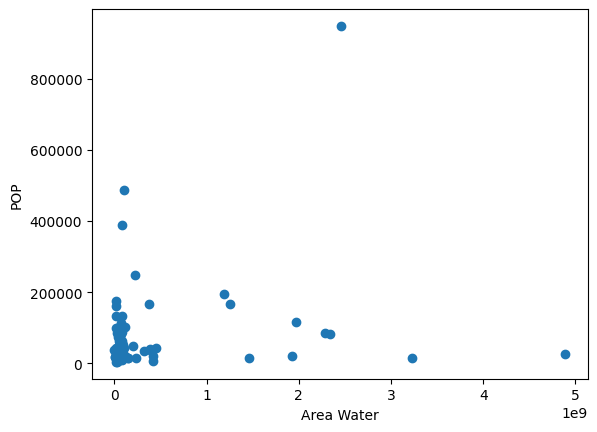

In [19]:
#Q15
areawater = counties_tracts_area['AREAWATER']
counties['AREAWATER'] = areawater

plt.xlabel('Area Water')
plt.ylabel('POP')
plt.scatter(counties['AREAWATER'], counties['POP100'])


In [20]:
tractsDF = gpd.read_file('tracts.shp')
tractsDF

,GEOID,POP100,geometry
0,55001950204,1646,"POLYGON ((-90.02638 44.08721, -90.02627 44.089..."
1,55009940002,4698,"POLYGON ((-88.15018 44.51202, -88.15010 44.513..."
2,55061990000,0,"POLYGON ((-87.53727 44.33179, -87.53547 44.334..."
3,55009020100,5817,"POLYGON ((-87.93753 44.67821, -87.89338 44.678..."
4,55009010100,6506,"POLYGON ((-88.06825 44.45368, -88.05841 44.461..."
...,...,...,...
1537,55139003100,2046,"POLYGON ((-88.47454 44.19198, -88.47450 44.192..."
1538,55079017900,2879,"POLYGON ((-87.91064 42.99520, -87.91038 42.995..."
1539,55059000800,2763,"POLYGON ((-87.84574 42.60276, -87.84548 42.602..."
1540,55025013700,7107,"POLYGON ((-89.57788 42.98135, -89.57788 42.981..."


In [21]:
land_use = {"open_water": 11,
            "ice_snow": 12,
            "developed_open": 21,
            "developed_low": 22,
            "developed_med": 23,
            "developed_high": 24,
            "barren": 31,
            "deciduous": 41,
            "evergreen": 42,
            "mixed_forest": 43,
            "dwarf_scrub": 51,
            "shrub_scrub": 52,
            "grassland": 71,
            "sedge": 72,
            "lichens": 73,
            "moss": 74,
            "pasture": 81,
            "crops": 82,
            "woody_wetlands": 90,
            "herbacious_wetlands": 95}
tractsDF = tractsDF.to_crs(land.crs)
for i in tractsDF.index:
  geom = tractsDF.loc[i, 'geometry']
  matrix, _ = mask(land, [geom], crop=True)
  matrix = matrix[0]
  for j in land_use:
     tractsDF.loc[i, j] = sum(sum(matrix == land_use[j]))

In [22]:
tractsDF

,GEOID,POP100,geometry,open_water,ice_snow,developed_open,developed_low,developed_med,developed_high,barren,...,dwarf_scrub,shrub_scrub,grassland,sedge,lichens,moss,pasture,crops,woody_wetlands,herbacious_wetlands
0,55001950204,1646,"POLYGON ((476459.321 2359023.337, 476451.046 2...",55465.0,0.0,12351.0,5402.0,833.0,104.0,175.0,...,0.0,18518.0,33652.0,0.0,0.0,0.0,3136.0,73433.0,84766.0,20975.0
1,55009940002,4698,"POLYGON ((621899.492 2417088.085, 621887.848 2...",57.0,0.0,1456.0,2104.0,1211.0,243.0,229.0,...,0.0,23.0,38.0,0.0,0.0,0.0,770.0,1503.0,2317.0,123.0
2,55061990000,0,"POLYGON ((672119.958 2401253.560, 672233.404 2...",2107187.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,55009020100,5817,"POLYGON ((637138.410 2436942.838, 640613.785 2...",117008.0,0.0,6209.0,7738.0,1971.0,337.0,718.0,...,0.0,60.0,327.0,0.0,0.0,0.0,17419.0,112681.0,26017.0,2677.0
4,55009010100,6506,"POLYGON ((628917.973 2411150.565, 629625.110 2...",530.0,0.0,1141.0,2711.0,1109.0,174.0,2.0,...,0.0,0.0,52.0,0.0,0.0,0.0,23.0,2.0,79.0,47.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1537,55139003100,2046,"POLYGON ((599079.049 2379457.015, 599081.372 2...",2848.0,0.0,119.0,676.0,467.0,299.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,51.0,0.0,40.0,0.0
1538,55079017900,2879,"POLYGON ((655219.585 2250069.887, 655234.899 2...",0.0,0.0,0.0,38.0,491.0,153.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1539,55059000800,2763,"POLYGON ((664221.429 2206827.091, 664242.297 2...",0.0,0.0,328.0,163.0,748.0,200.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1540,55025013700,7107,"POLYGON ((520513.435 2238213.310, 520512.428 2...",329.0,0.0,1215.0,2209.0,1799.0,477.0,21.0,...,0.0,42.0,52.0,0.0,0.0,0.0,3861.0,8236.0,382.0,371.0


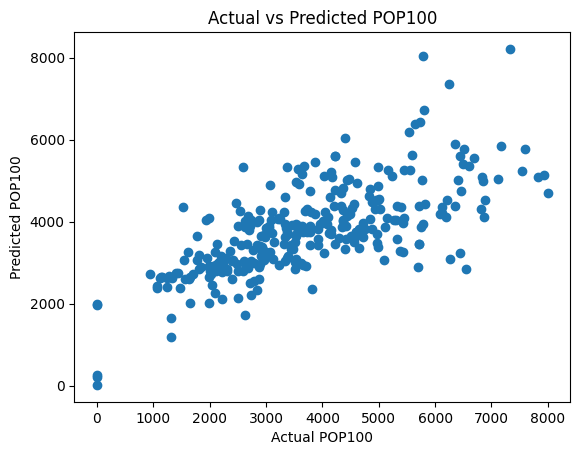

1141.9819832468177


In [23]:
tractsDF
y = tractsDF['POP100'] 
x = tractsDF.loc[:, 'open_water':'herbacious_wetlands']
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size=0.20, random_state=300)
model = sklearn.linear_model.LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
# Scatter plot of actual vs predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual POP100')
plt.ylabel('Predicted POP100')
plt.title('Actual vs Predicted POP100')
plt.show()
print(math.sqrt(sklearn.metrics.mean_squared_error(y_test, y_pred)))
############################################
# It appears from the graph that there is a weak linear relationship between actual and predicted population. There is 
# an RMSE of about 1150. It appears that there are multiple areas of improvement when I make my model. 

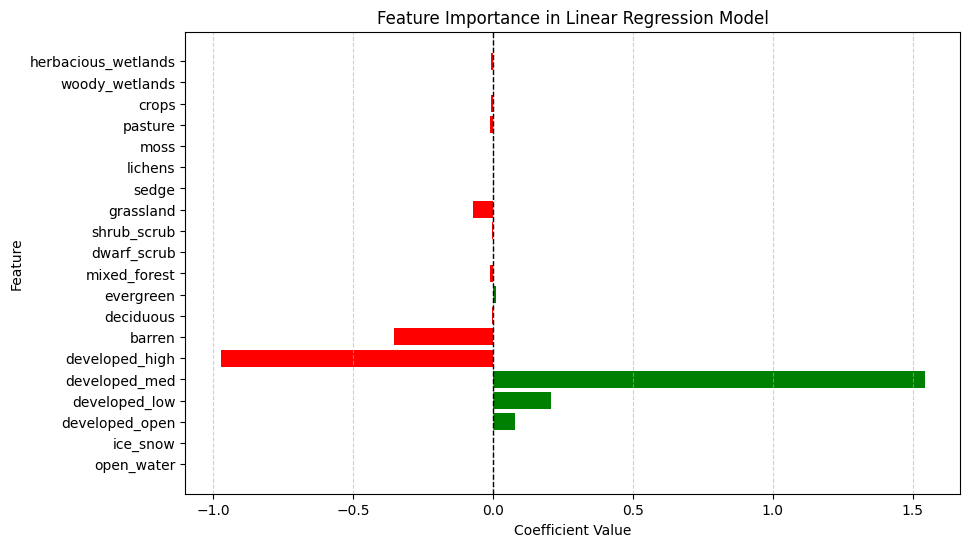

In [24]:
#Q16
feature_names = x.columns
coefficients = model.coef_

plt.figure(figsize=(10, 6))
plt.barh(feature_names, coefficients, color=np.where(coefficients >= 0, 'green', 'red'))  # Color positive coefficients in green, negative in red
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)  # Add a vertical line at zero
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance in Linear Regression Model')
plt.grid(axis='x', linestyle='--', alpha=0.6)
#########################################
# It appears that the regression model places the most importance on medium-developed areas and the least importance on
# high-developed areas. 

In [25]:
# FIRST REGRESSION MODEL: Predicting POP100 with developed_med
y = tractsDF['POP100'] 
x = tractsDF['developed_med']
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size=0.20, random_state=300)
X_train = np.array(x_train).reshape(-1, 1)  # Reshape to a 2D array
Y_train = np.array(y_train).reshape(-1, 1)
model = sklearn.linear_model.LinearRegression()
cross_val_score = sklearn.model_selection.cross_val_score(model, X_train, Y_train)
firstModelAvg = np.average(cross_val_score)
firstModelVariance = np.var(cross_val_score)
print("First Model Average: " + str(firstModelAvg))
print("First Model Variance: " + str(firstModelVariance))
#######################################
# SECOND REGRESSION MODEL: Predicting POP100 with developed_med, developed_low, and developed_open and using transformers
y = tractsDF['POP100'] 
x = tractsDF.loc[:, 'developed_open':'developed_med']
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size=0.20, random_state=300)
Y_train = np.array(y_train).reshape(-1, 1)
continuous = ['developed_med', 'developed_low', 'developed_open']
imputer_c = sklearn.impute.SimpleImputer(strategy = "median")
imputer_d = sklearn.impute.SimpleImputer(strategy = "constant", fill_value = "None")
transformer_c = sklearn.preprocessing.StandardScaler()
transformer_d = sklearn.preprocessing.OneHotEncoder()
steps_c = sklearn.pipeline.Pipeline(steps = [("ic", imputer_c), ("tc", transformer_c)])
steps_d = sklearn.pipeline.Pipeline(steps = [("id", imputer_d), ("td", transformer_d)])
pre = sklearn.compose.ColumnTransformer(transformers = [("c", steps_c, continuous)])
model = sklearn.pipeline.Pipeline(steps = [("pre", pre), ("clf", sklearn.linear_model.LinearRegression())])
cross_val_score = sklearn.model_selection.cross_val_score(model, x_train, y_train)
secondModelAvg = np.average(cross_val_score)
secondModelVariance = np.var(cross_val_score)
print("Second Model Average: " + str(secondModelAvg))
print("Second Model Variance: " + str(secondModelVariance))

First Model Average: 0.379921514850355
First Model Variance: 0.0022518587163339113
Second Model Average: 0.4030454972981231
Second Model Variance: 0.002636530423896935


In [26]:
#Q17
# Based on the results from the two regression models, I think that the second regression model is better for this prediction task since the mean of the 
# cross validation scores is higher than the first model and the variance is about the same. 
model.fit(x_train, Y_train)
Y_test = np.array(y_test).reshape(-1, 1)
model.score(x_test, Y_test)

0.376592710092445